# Creating a route planner for a road network

In [2]:
import io
import zipfile
import requests
import networkx as nx
import numpy as np
import pandas as pd
import json
import smopy
import matplotlib.pyplot as plt
from osgeo import gdal
%matplotlib inline

In [19]:
# Load Roads Network

url = ('https://github.com/safarzadeh-reza/Sample-Code_Rout-Planning/blob/master/teh_road.zip?raw=true')

r = io.BytesIO(requests.get(url).content)
zipfile.ZipFile(r).extractall('data')

g = nx.read_shp('teh_road_GCS.shp')

BadZipFile: File is not a zip file

In [3]:
# Connected subgraphs

def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [4]:
# Take the largest connected subgraph

sgs = list(connected_component_subgraphs(g.to_undirected()))
# sgs = list(nx.connected_components(
#     g.to_undirected()))
i = np.argmax([len(sg) for sg in sgs])

sg = sgs[i]
len(sg)


2771

In [6]:
# Define two positions (with the latitude and longitude) in order to find shortest path between them

pos0 = (35.69974, 51.34284)
pos1 = (35.69457, 51.37868)

In [7]:
# If n0 and n1 are connected nodes in the graph,
# this function returns an array of point
# coordinates along the road linking these two
# nodes.

def get_path(n0, n1):
    return np.array(json.loads(sg[n0][n1]['Json'])['coordinates'])

In [8]:
# Computing the distance between any two points in
# geographical coordinates:

EARTH_R = 6372.8

def geocalc(lat0, lon0, lat1, lon1):
    """Return the distance (in km) between two points
    in geographical coordinates."""
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    dlon = lon0 - lon1
    y = np.sqrt((np.cos(lat1) * np.sin(dlon)) ** 2 +
        (np.cos(lat0) * np.sin(lat1) - np.sin(lat0) *
         np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    return EARTH_R * c

In [9]:
# Computing path's length

def get_path_length(path):
    return np.sum(geocalc(path[1:, 1], path[1:, 0],
                          path[:-1, 1], path[:-1, 0]))

In [10]:
# Update the graph by computing the distance between any two connected nodes.

for n0, n1 in sg.edges:
    path = get_path(n0, n1)
    distance = get_path_length(path)
    sg.edges[n0, n1]['distance'] = distance


In [11]:
nodes = np.array(sg.nodes())
# Get the closest nodes in the graph.
pos0_i = np.argmin(
    np.sum((nodes[:, ::-1] - pos0)**2, axis=1))
pos1_i = np.argmin(
    np.sum((nodes[:, ::-1] - pos1)**2, axis=1))

In [12]:
# Compute the shortest path.

# The path variable contains the list of edges that
# form the shortest path between our two positions

path = nx.shortest_path(
    sg,
    source=tuple(nodes[pos0_i]),
    target=tuple(nodes[pos1_i]),
    weight='distance')
len(path)


15

In [14]:
# Get information about the itinerary

roads = pd.DataFrame(
    [sg.edges[path[i], path[i + 1]]
     for i in range(len(path) - 1)],
    columns=['fclass', 'name',
             'Shape_Leng', 'distance'])
roads

,fclass,name,Shape_Leng,distance
0,primary,خیابان آزادی,1799.702030,1.796955
1,primary,خیابان آزادی,78.704872,0.078580
2,primary,خیابان آزادی,630.514990,0.629514
3,primary,خیابان آزادی,13.612999,0.013591
4,primary,خیابان آزادی,688.754039,0.687662
5,primary,خیابان آزادی,265.327382,0.264906
6,primary,خیابان آزادی,19.034792,0.019004
7,primary,خیابان آزادی,1161.029921,1.159214
8,primary,کارگر جنوبی,825.229280,0.827480
9,secondary,آذربایجان,544.443431,0.543598


In [15]:
# Total length of this itinerary

roads['distance'].sum()

6.713116525187184

In [16]:
# Display the itinerary on the map using Smopy (OpenStreetMap image tiles in Python)

m = smopy.Map(pos0, pos1, z=14, margin=.1)

In [17]:
# Return the positions along a path

# The last point in an edge needs to be close to the first
# point in the next edge

def get_full_path(path):
    p_list = []
    curp = None
    for i in range(len(path) - 1):
        p = get_path(path[i], path[i + 1])
        if curp is None:
            curp = p
        if (np.sum((p[0] - curp) ** 2) >
                np.sum((p[-1] - curp) ** 2)):
            p = p[::-1, :]
        p_list.append(p)
        curp = p[-1]
    return np.vstack(p_list)

In [18]:
# Convert the path into pixels

linepath = get_full_path(path)
x, y = m.to_pixels(linepath[:, 1], linepath[:, 0])

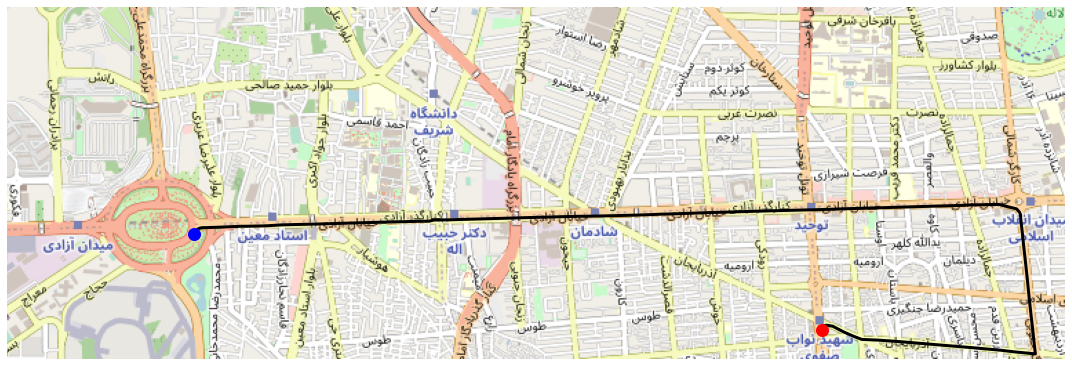

In [19]:
ax = m.show_mpl(figsize=(15, 15))

# Plot the itinerary.
ax.plot(x, y, '-k', lw=3)

# Mark our two positions.
ax.plot(x[0], y[0], 'ob', ms=12)
ax.plot(x[-1], y[-1], 'or', ms=12)